# CUSTOMER CHURN CHALLENGE ON ZINDI

# Project Description

This challenge is for an African telecommunications company that provides customers with airtime and mobile data bundles. The objective of this challenge is to develop a machine learning model to predict the likelihood of each customer “churning”, i.e. becoming inactive and not making any transactions for 90 days.

This solution will help this telecom company to better serve their customers by understanding which customers are at risk of leaving.

# Hypothesis

Null Hypothesis: There is no relationship between the tenure and the churn of customers.

Alternate Hypothesis: There is a relationship between the tenure and the churn of customers.

# Analytical Questions

1. What is the overall churn rate of the telecommunication company?
2. What is the churn rate across the various locations?
3. What is the churn rate of custmers based on customer regularity?
4. What is the churn rate of customers based on their tenure?
(Group customers to short-term, mid-term and long term based on their tenure, then check the churn rate)
5. What is the churn rate of customers based on the top_up amounts?
(Group top_up amount to high, medium and low, then check the churn rate across the groups)
6. What is the churn rate of top pack users?
7. What is the churn rate based on the data volume?
8. What is the churn rate of custmers based on their income frequency?
9. What is the churn rate of customers based on their monthly income?
(Group monthly income to high-income earners, medium income earners, and low income earners, then check the churn rate across them)
10. What is the relationship between the monthly income of customers and the frequency of their recharge (the number of times a customer activated the top pack packages)?
11. What is the relationship between the number of times a customer made an income and the number of times a customer activated the top pack?
12. What is the churn distribution of customers based on calls to Zone1 and Zone 2?
13. What is the churn distribution of customers based international calls, calls to Orange, and calls to Tigo?

In [3]:
# Installations

!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 2.8 MB/s eta 0:00:00


In [4]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import os
from google.colab import drive

import scipy.stats as stats

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from huggingface_hub import notebook_login

# Data Exploration

In [9]:
# Load the datasets

# train = pd.read_csv('Train.csv')
# test=  pd.read_csv('Test.csv')
# submission = pd.read_csv('SampleSubmission.csv')

In [5]:
# Mount Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# Define the directory path to access the datasets
data_path = '/content/drive/MyDrive/Google Colab/Customer Churn Challenge on Zindi/Assets/'

# Define the directory path to save images
image_path = '/content/drive/MyDrive/Google Colab/Customer Churn Challenge on Zindi/Images'

In [34]:
# Load the datasets from the drive using the data_path

train = pd.read_csv(data_path + 'Train.csv')
test=  pd.read_csv(data_path + 'Test.csv')
submission = pd.read_csv(data_path + 'SampleSubmission.csv')

In [8]:
# Display the first five rows of the train dataset

train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,7ee9e11e342e27c70455960acc80d3f91c1286d1,DAKAR,K > 24 month,20000.0,47.0,21602.0,7201.0,52.0,8835.0,3391.0,396.0,185.0,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,30.0,0
1,50443f42bdc92b10388fc56e520e4421a5fa655c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
2,da90b5c1a9b204c186079f89969aa01cb03c91b2,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN,0
3,364ec1b424cdc64c25441a444a16930289a0051e,SAINT-LOUIS,K > 24 month,7900.0,19.0,7896.0,2632.0,25.0,9385.0,27.0,46.0,20.0,NaN,2.0,NO,61,"Data:490F=1GB,7d",7.0,0
4,d5a5247005bc6d41d3d99f4ef312ebb5f640f2cb,DAKAR,K > 24 month,12350.0,21.0,12351.0,4117.0,29.0,9360.0,66.0,102.0,34.0,NaN,NaN,NO,56,All-net 500F=2000F;5d,11.0,0


In [10]:
# Display the last five rows of the train dataset

train.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
1077019,56e22fe3312a48cf860b043a021dab275383a20a,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,16,NaN,NaN,0
1077020,587b72930e4d36b3fb94a18c3ef65c2079460eee,TAMBACOUNDA,K > 24 month,2500.0,5.0,2500.0,833.0,5.0,0.0,15.0,77.0,NaN,NaN,NaN,NO,34,All-net 500F=2000F;5d,2.0,0
1077021,d6831b8edacb7d9928b3f053fb1283574577ae42,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,1
1077022,cb1f6510b084173c0deae49095f35ac29f916701,NaN,K > 24 month,600.0,1.0,600.0,200.0,1.0,591.0,11.0,37.0,5.0,1.0,NaN,NO,16,All-net 600F= 3000F ;5d,1.0,0
1077023,28f56fd0d9f8d8647bb6c62e7a3f4f35f49f4d6f,FATICK,K > 24 month,1500.0,4.0,1499.0,500.0,5.0,1265.0,30.0,4.0,NaN,NaN,0.0,NO,50,On net 200F=Unlimited _call24H,2.0,0


In [11]:
# Obtain the shape of the train data

train.shape

(1077024, 19)

In [12]:
# View columns of the train data and their datatypes

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077024 entries, 0 to 1077023
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1077024 non-null  object 
 1   REGION          652687 non-null   object 
 2   TENURE          1077024 non-null  object 
 3   MONTANT         699139 non-null   float64
 4   FREQUENCE_RECH  699139 non-null   float64
 5   REVENUE         714669 non-null   float64
 6   ARPU_SEGMENT    714669 non-null   float64
 7   FREQUENCE       714669 non-null   float64
 8   DATA_VOLUME     547261 non-null   float64
 9   ON_NET          683850 non-null   float64
 10  ORANGE          629880 non-null   float64
 11  TIGO            432250 non-null   float64
 12  ZONE1           84898 non-null    float64
 13  ZONE2           68794 non-null    float64
 14  MRG             1077024 non-null  object 
 15  REGULARITY      1077024 non-null  int64  
 16  TOP_PACK        626129 non-null   ob

In [13]:
# Display the first five rows of the test dataset

test.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,MATAM,I 18-21 month,2500.0,5.0,2500.0,833.0,5.0,0.0,64.0,70.0,NaN,NaN,NaN,NO,35,All-net 500F=2000F;5d,5.0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
2,5a4db591c953a8d8f373877fad37aaf4268899a1,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NO,22,NaN,NaN
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,SAINT-LOUIS,K > 24 month,5100.0,7.0,5637.0,1879.0,15.0,7783.0,30.0,24.0,0.0,0.0,NaN,NO,60,"Data:1000F=2GB,30d",4.0


In [14]:
# Display the last five rows of the test dataset

test.tail()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
190058,1092956a3dad77ceb7e8d7c70e3e13f77b60e2aa,DAKAR,F 9-12 month,500.0,1.0,506.0,169.0,1.0,0.0,26.0,NaN,NaN,6.0,NaN,NO,14,All-net 500F=2000F;5d,1.0
190059,bec10becca7faa8e9cab9981b3aee5e9a7f04828,DAKAR,K > 24 month,2000.0,4.0,2000.0,667.0,5.0,0.0,8.0,54.0,NaN,NaN,NaN,NO,29,All-net 500F =2000F_AllNet_Unlimited,3.0
190060,7ac6fc191f8732b1b146e57f9ede983626b93eae,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
190061,d592c81971d6120b0d19f9ace85f278ea21b89a0,NaN,K > 24 month,300.0,2.0,298.0,99.0,2.0,0.0,1.0,2.0,NaN,NaN,NaN,NO,12,NaN,NaN
190062,9b4f57aeef72cd52c634498d0ea27ea3fbb67bf4,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN


In [15]:
# Obtain the shape of the test dataset

test.shape

(190063, 18)

In [16]:
# View the columns and datatypes of the test dataset

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190063 entries, 0 to 190062
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         190063 non-null  object 
 1   REGION          115330 non-null  object 
 2   TENURE          190063 non-null  object 
 3   MONTANT         123695 non-null  float64
 4   FREQUENCE_RECH  123695 non-null  float64
 5   REVENUE         126422 non-null  float64
 6   ARPU_SEGMENT    126422 non-null  float64
 7   FREQUENCE       126422 non-null  float64
 8   DATA_VOLUME     96716 non-null   float64
 9   ON_NET          120771 non-null  float64
 10  ORANGE          111417 non-null  float64
 11  TIGO            76555 non-null   float64
 12  ZONE1           14850 non-null   float64
 13  ZONE2           12011 non-null   float64
 14  MRG             190063 non-null  object 
 15  REGULARITY      190063 non-null  int64  
 16  TOP_PACK        110773 non-null  object 
 17  FREQ_TOP_P

In [17]:
# List all the columns in the train and test dataset

train.columns, test.columns

(Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
        'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
        'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
        'CHURN'],
       dtype='object'),
 Index(['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
        'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
        'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK'],
       dtype='object'))

The train and test datatypes have the same columns with the same datatypes, except that the train dataset has a 'CHURN' column which is absent in the test data. This 'CHURN' column is the target variable.

In [18]:
# Display the first five rows of the submission dataset

submission.head()

,user_id,CHURN
0,51fe4c3347db1f8571d18ac03f716c41acee30a4,0
1,5ad5d67c175bce107cc97b98c4e37dcc38aa7f3e,0
2,5a4db591c953a8d8f373877fad37aaf4268899a1,0
3,8bf9b4d8880aeba1c9a0da48be78f12e629be37c,0
4,c7cdf2af01e9fa95bf498b68c122aa4b9a8d10df,0


In [19]:
# Obtain the shape of the submission dataset

submission.shape

(190063, 2)

# Visualization of some columns in the *dataset*

DAKAR          256259
THIES           90171
SAINT-LOUIS     59895
LOUGA           49679
KAOLACK         48498
DIOURBEL        33564
TAMBACOUNDA     27562
KAFFRINE        22067
KOLDA           19464
FATICK          17775
MATAM           14650
ZIGUINCHOR      11036
SEDHIOU          1553
KEDOUGOU          514
Name: REGION, dtype: int64


Text(0.5, 0, 'REGION')

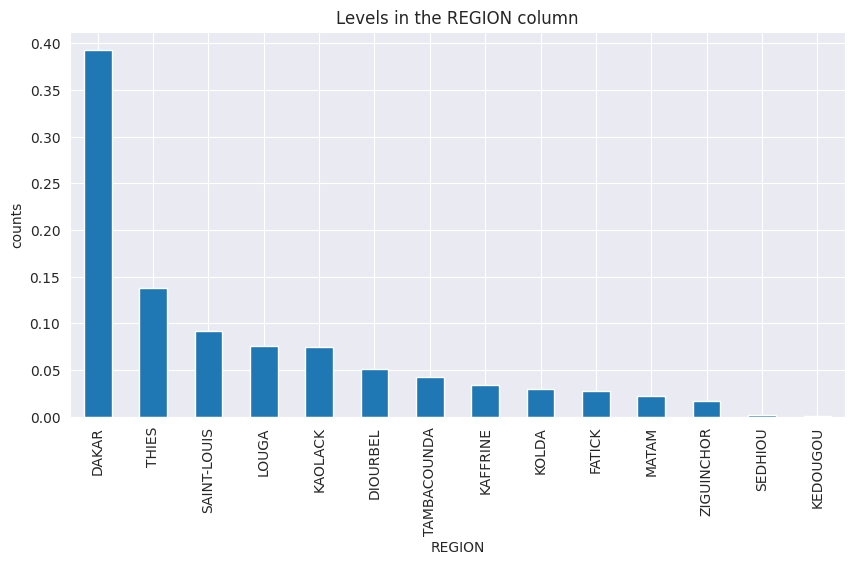

In [20]:
# Check the levels in the 'REGION' column

print(train['REGION'].value_counts())
plt.figure(figsize=(10,5))
train['REGION'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the REGION column')
plt.ylabel('counts')
plt.xlabel('REGION')

From the plot above, most of the customers are located in Dakar, followed by Thies and Saint-Louis. Kedougou is the region with the least number of customers.

K > 24 month     1021853
I 18-21 month      22494
H 15-18 month      12913
G 12-15 month       7520
J 21-24 month       6324
F 9-12 month        4604
E 6-9 month          929
D 3-6 month          387
Name: TENURE, dtype: int64


Text(0.5, 0, 'TENURE')

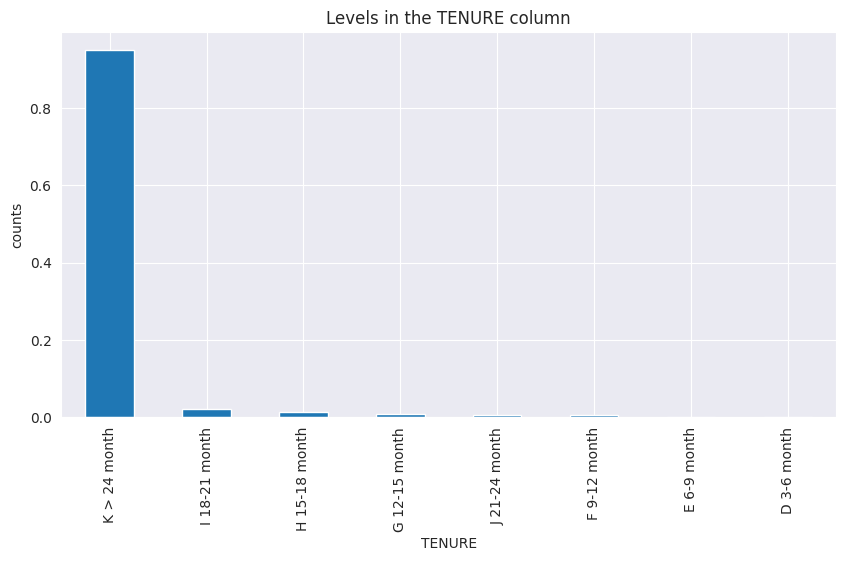

In [21]:
# Check the levels in the 'TENURE' column

print(train['TENURE'].value_counts())
plt.figure(figsize=(10,5))
train['TENURE'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the TENURE column')
plt.ylabel('counts')
plt.xlabel('TENURE')

A huge percentage of the customers captured in the train dataset have stayed with the telecommunication company for over 24 months. This implies that the dataset is focused on old customers.

K > 24 month     180265
I 18-21 month      4017
H 15-18 month      2287
G 12-15 month      1369
J 21-24 month      1096
F 9-12 month        811
E 6-9 month         153
D 3-6 month          65
Name: TENURE, dtype: int64


Text(0.5, 0, 'TENURE')

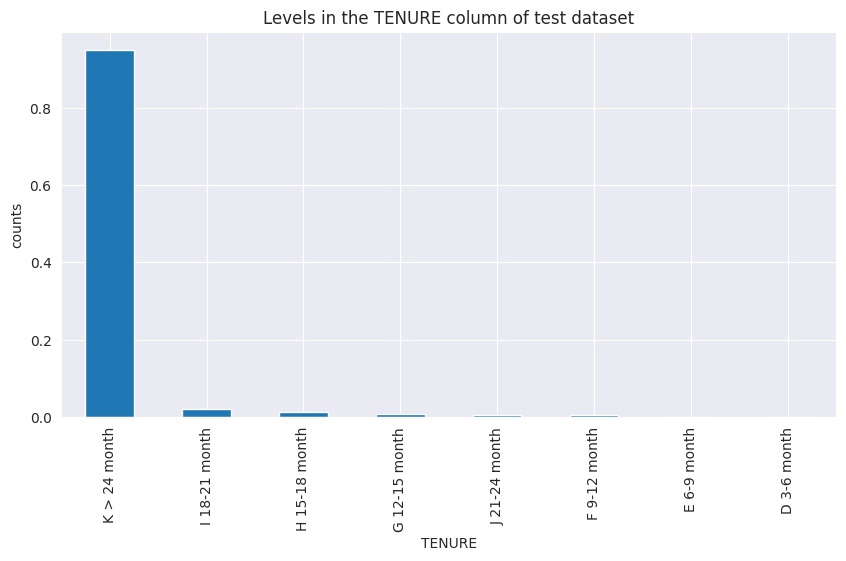

In [22]:
# Check the levels in the TENURE column of test dataset

print(test['TENURE'].value_counts())
plt.figure(figsize=(10,5))
test['TENURE'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the TENURE column of test dataset')
plt.ylabel('counts')
plt.xlabel('TENURE')

Both the train and test datasets focus on old customers, that is, customers that have been with the telecommunication network for over 24 months.

NO    1077024
Name: MRG, dtype: int64


Text(0.5, 0, 'MRG')

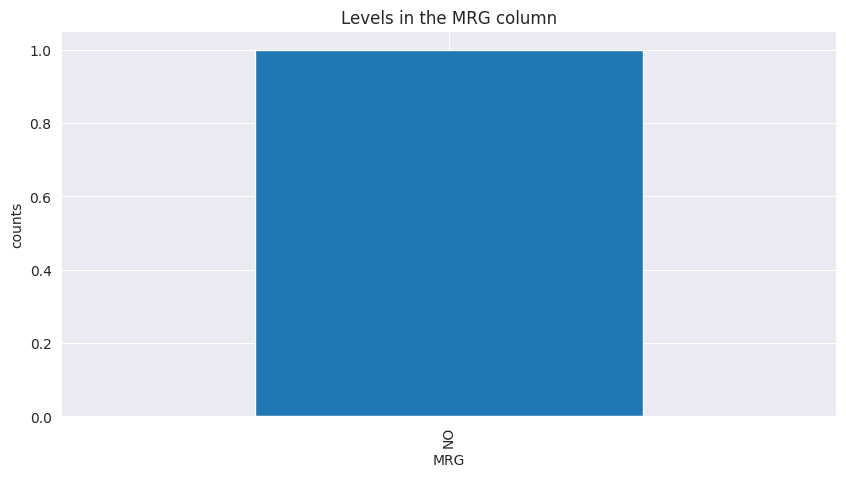

In [23]:
# Check the levels in the MRG column

print(train['MRG'].value_counts())
plt.figure(figsize=(10,5))
train['MRG'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the MRG column')
plt.ylabel('counts')
plt.xlabel('MRG')

The MRG indicates if a client is going. The chart above shows that none of the customers in the train dataset is going.

NO    190063
Name: MRG, dtype: int64


Text(0.5, 0, 'MRG')

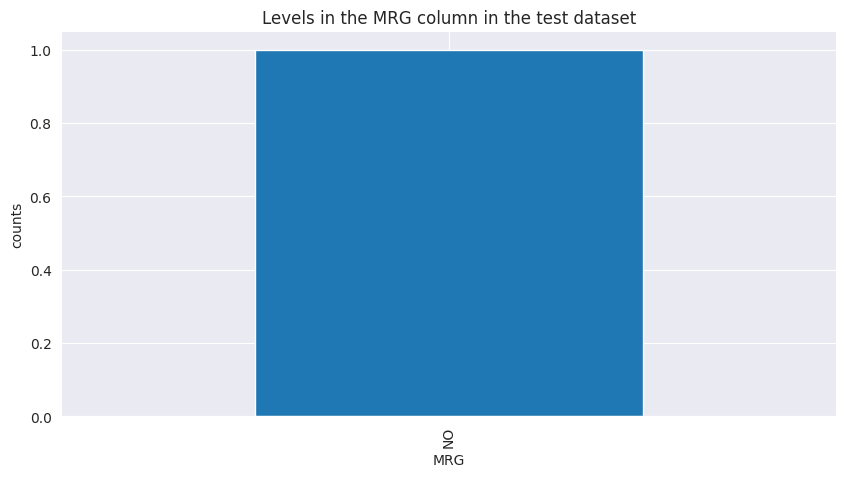

In [24]:
# Check the levels in the MRG column in the test dataset

print(test['MRG'].value_counts())
plt.figure(figsize=(10,5))
test['MRG'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the MRG column in the test dataset')
plt.ylabel('counts')
plt.xlabel('MRG')

The MRG indicates if a client is going. The chart above shows that none of the customers in the test dataset is going.

All-net 500F=2000F;5d                          158779
On net 200F=Unlimited _call24H                  76302
Data:490F=1GB,7d                                57679
Data: 100 F=40MB,24H                            42515
Mixt 250F=Unlimited_call24H                     33620
MIXT:500F= 2500F on net _2500F off net;2d       32164
Data:1000F=2GB,30d                              29982
All-net 500F =2000F_AllNet_Unlimited            23476
Jokko_Daily                                     22548
Data: 200 F=100MB,24H                           21515
IVR Echat_Daily_50F                             14316
On-net 500=4000,10d                             13371
On-net 500F_FNF;3d                              11089
Data:200F=Unlimited,24H                         10986
MIXT: 200mnoff net _unl on net _5Go;30d          9612
On-net 1000F=10MilF;10d                          9302
Data:1000F=5GB,7d                                7470
VAS(IVR_Radio_Daily)                             7376
Twter_U2opia_Daily          

Text(0.5, 0, 'TOP_PACK')

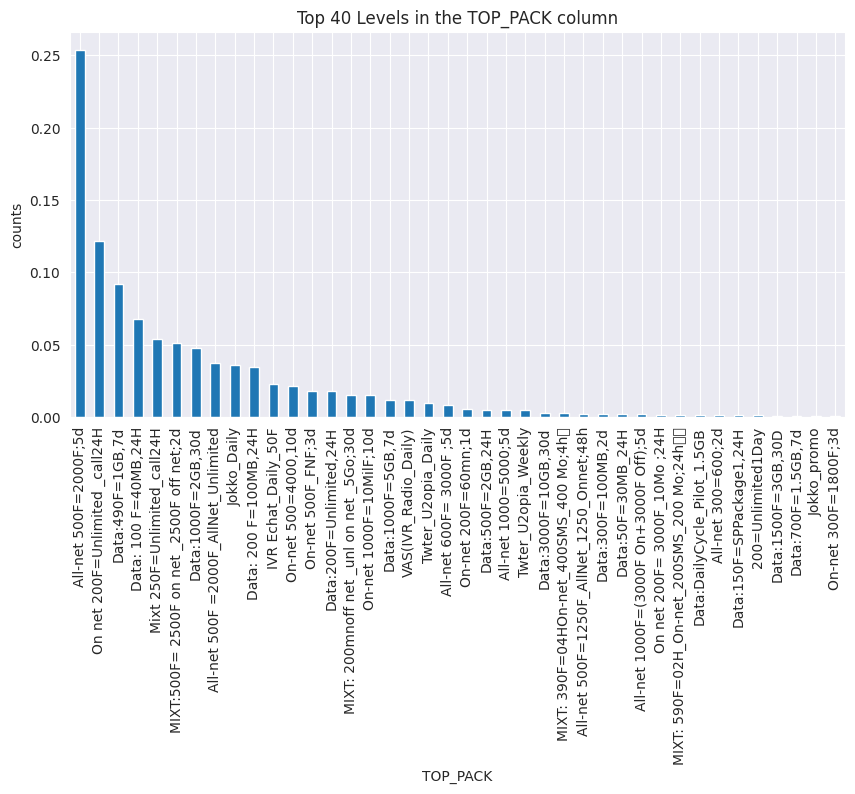

In [25]:
# Check the top 40 levels in the TOP_PACK column

print(train['TOP_PACK'].value_counts().head(40))
plt.figure(figsize=(10,5))
train['TOP_PACK'].value_counts(normalize=True).head(40).plot(kind='bar')
plt.title('Top 40 Levels in the TOP_PACK column')
plt.ylabel('counts')
plt.xlabel('TOP_PACK')

0    875031
1    201993
Name: CHURN, dtype: int64


Text(0.5, 0, 'CHURN')

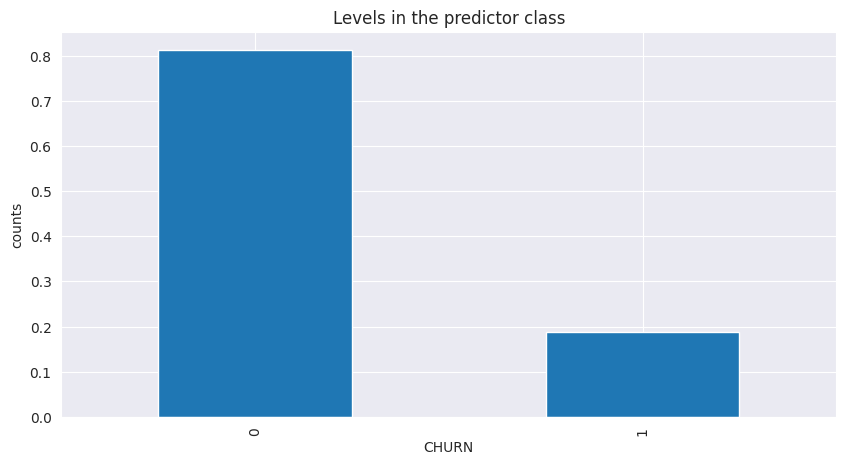

In [26]:
# Check if the predictor class is balanced

print(train['CHURN'].value_counts())
plt.figure(figsize=(10,5))
train['CHURN'].value_counts(normalize=True).plot(kind='bar')
plt.title('Levels in the predictor class')
plt.ylabel('counts')
plt.xlabel('CHURN')

In [27]:
# Check the summary of numerical fields and apply transpose to easily display all the columns

summary_statistics = train.select_dtypes(include=['int64', 'float64']).describe().T
summary_statistics

,count,mean,std,min,25%,50%,75%,max
MONTANT,699139.0,5529.210895,7104.737952,20.0,1000.0,3000.0,7350.0,470000.0
FREQUENCE_RECH,699139.0,11.523756,13.261938,1.0,2.0,7.0,16.0,131.0
REVENUE,714669.0,5506.050798,7175.625010,1.0,1000.0,3000.0,7360.0,532177.0
ARPU_SEGMENT,714669.0,1835.355961,2391.870902,0.0,333.0,1000.0,2453.0,177392.0
FREQUENCE,714669.0,13.974439,14.687059,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,547261.0,3368.801722,12898.928039,0.0,0.0,258.0,2905.0,1702309.0
ON_NET,683850.0,277.065798,874.315378,0.0,5.0,27.0,156.0,50809.0
ORANGE,629880.0,95.160804,203.020261,0.0,7.0,29.0,99.0,12040.0
TIGO,432250.0,23.105018,64.035464,0.0,2.0,6.0,20.0,4174.0
ZONE1,84898.0,8.167483,39.245883,0.0,0.0,1.0,3.0,2507.0


<Axes: >

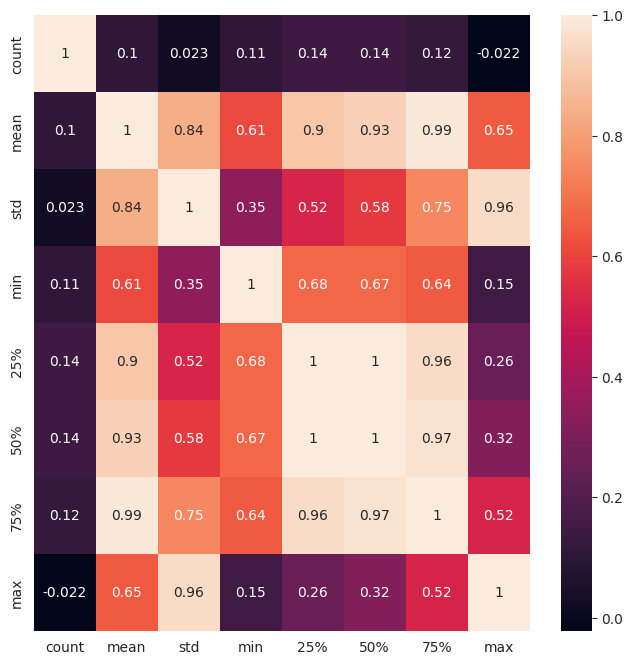

In [28]:
# Plot the correlation matrix using heatmap

sb.heatmap(summary_statistics.corr(), annot=True)

In [29]:
# Check for missing values in train dataset

train.isnull().sum()

user_id                 0
REGION             424337
TENURE                  0
MONTANT            377885
FREQUENCE_RECH     377885
REVENUE            362355
ARPU_SEGMENT       362355
FREQUENCE          362355
DATA_VOLUME        529763
ON_NET             393174
ORANGE             447144
TIGO               644774
ZONE1              992126
ZONE2             1008230
MRG                     0
REGULARITY              0
TOP_PACK           450895
FREQ_TOP_PACK      450895
CHURN                   0
dtype: int64

In [30]:
# Check for missing values in test dataset

test.isnull().sum()

user_id                0
REGION             74733
TENURE                 0
MONTANT            66368
FREQUENCE_RECH     66368
REVENUE            63641
ARPU_SEGMENT       63641
FREQUENCE          63641
DATA_VOLUME        93347
ON_NET             69292
ORANGE             78646
TIGO              113508
ZONE1             175213
ZONE2             178052
MRG                    0
REGULARITY             0
TOP_PACK           79290
FREQ_TOP_PACK      79290
dtype: int64

# Hypothesis Testing

Null Hypothesis: There is no relationship between the tenure and the churn of customers.

Alternate Hypothesis: There is a relationship between the tenure and the churn of customers.

In [31]:
# Define the null hypothesis and alternative hypothesis
null_hypothesis = 'There is no relationship between the tenure and churn of customers.'
alternative_hypothesis = 'There is a relationship between the tenure and churn of customers.'

# Perform the chi-square test
observed = pd.crosstab(train['TENURE'], train['CHURN'])
chi2, p_value, _, _ = stats.chi2_contingency(observed)

# Set the significance level
alpha = 0.05

# Print the test results
print('Null Hypothesis:', null_hypothesis)
print('Alternative Hypothesis:', alternative_hypothesis)
print('Significance Level (alpha):', alpha)
print('Chi-square statistic:', chi2)
print('P-value:', p_value)

# Compare the p-value with the significance level
if p_value < alpha:

    print(f'Result: Reject the null hypothesis.', alternative_hypothesis)
else:
    print(f'Result: Fail to reject the null hypothesis.', null_hypothesis)

Null Hypothesis: There is no relationship between the tenure and churn of customers.
Alternative Hypothesis: There is a relationship between the tenure and churn of customers.
Significance Level (alpha): 0.05
Chi-square statistic: 2898.5207691813353
P-value: 0.0
Result: Reject the null hypothesis. There is a relationship between the tenure and churn of customers.


 The P-value of 0.0 suggests a strong evidence against the null hypothesis, indicating a statistically significant result. There is a strong relationship between customer tenure and customer churn.

# Answering Analytical Questions

## Questions

1. What is the overall churn rate of the telecommunication company?
2. What is the churn rate across the various locations?
3. What is the churn rate of custmers based on customer regularity?
4. What is the churn rate of customers based on their tenure?
(Group customers to short-term, mid-term and long term based on their tenure, then check the churn rate)
5. What is the churn rate of customers based on the top_up amounts?
(Group top_up amount to high, medium and low, then check the churn rate across the groups)
6. What is the churn rate of top pack users?
7. What is the churn rate based on the data volume?
8. What is the churn rate of custmers based on their income frequency?
9. What is the churn rate of customers based on their monthly income?
(Group monthly income to high-income earners, medium income earners, and low income earners, then check the churn rate across them)
10. What is the relationship between the monthly income of customers and the frequency of their recharge (the number of times a customer activated the top pack packages)?
11. What is the relationship between the number of times a customer made an income and the number of times a customer activated the top pack?
12. What is the churn distribution of customers based on calls to Zone1 and Zone 2?
13. What is the churn distribution of customers based international calls, calls to Orange, and calls to Tigo?

Question 1: What is the overall churn rate of the telecommunication company?

Question 2: What is the churn rate across the various locations?

Question 3: What is the churn rate of custmers based on customer regularity?

Question 4: What is the churn rate of customers based on their tenure?
(Group customers to short-term, mid-term and long term based on their tenure, then check the churn rate)

Question 5: What is the churn rate of customers based on the top_up amounts?
(Group top_up amount to high, medium and low, then check the churn rate across the groups)

# Feature Engineering

## Feature Selection

In [ ]:
#We will drop REGION, TOP_PACK, and MRG
#We will also replace the missing values for the numerical columns with their means (averages)

In [ ]:
train.drop(columns=['REGION', 'MRG', 'TOP_PACK'], inplace=True) #drop these columns

# Remember to also drop the 'user_id' column here

In [ ]:
train.head()

,user_id,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,K > 24 month,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,1.0,1.0,2.0,54,8.0,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,I 18-21 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,K > 24 month,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,7.0,NaN,NaN,17,1.0,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,K > 24 month,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,2.0,NaN,NaN,62,11.0,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,K > 24 month,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,NaN,NaN,NaN,11,2.0,0


In [ ]:
test.drop(columns=['REGION', 'MRG', 'TOP_PACK'], inplace=True)

In [ ]:
test.head()

,user_id,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,K > 24 month,5000.0,5.0,5000.0,1667.0,5.0,NaN,378.0,11.0,5.0,NaN,NaN,42,5.0
1,000055d41c8a62052dd426592e8a4a3342bf565d,I 18-21 month,300.0,2.0,326.0,109.0,3.0,397.0,NaN,0.0,NaN,NaN,NaN,41,1.0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,K > 24 month,3300.0,25.0,3400.0,1133.0,26.0,7150.0,0.0,2.0,5.0,NaN,NaN,57,22.0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN
4,0000bae5480628cf8fe51ad84bcb39772fc79224,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN


## Imputation

In [ ]:
#Fill NAs for train data

In [ ]:
train['MONTANT'].fillna((train['MONTANT'].mean()), inplace=True)
train['FREQUENCE_RECH'].fillna((train['FREQUENCE_RECH'].mean()), inplace=True)
train['REVENUE'].fillna((train['REVENUE'].mean()), inplace=True)
train['ARPU_SEGMENT'].fillna((train['ARPU_SEGMENT'].mean()), inplace=True)
train['FREQUENCE'].fillna((train['FREQUENCE'].mean()), inplace=True)
train['DATA_VOLUME'].fillna((train['DATA_VOLUME'].mean()), inplace=True)
train['ON_NET'].fillna((train['ON_NET'].mean()), inplace=True)
train['ORANGE'].fillna((train['ORANGE'].mean()), inplace=True)
train['TIGO'].fillna((train['TIGO'].mean()), inplace=True)
train['ZONE1'].fillna((train['ZONE1'].mean()), inplace=True)
train['ZONE2'].fillna((train['ZONE2'].mean()), inplace=True)
train['FREQ_TOP_PACK'].fillna((train['FREQ_TOP_PACK'].mean()), inplace=True)

In [ ]:
train.head()

,user_id,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
0,00000bfd7d50f01092811bc0c8d7b0d6fe7c3596,K > 24 month,4250.000000,15.00000,4251.000000,1417.000000,17.000000,4.000000,388.00000,46.000000,1.000000,1.000000,2.000000,54,8.000000,0
1,00000cb4a5d760de88fecb38e2f71b7bec52e834,I 18-21 month,5532.116998,11.52912,5510.810334,1836.942894,13.978141,3366.450167,277.68914,95.418711,23.109253,8.170132,7.553309,4,9.272461,1
2,00001654a9d9f96303d9969d0a4a851714a4bb57,K > 24 month,3600.000000,2.00000,1020.000000,340.000000,2.000000,3366.450167,90.00000,46.000000,7.000000,8.170132,7.553309,17,1.000000,0
3,00001dd6fa45f7ba044bd5d84937be464ce78ac2,K > 24 month,13500.000000,15.00000,13502.000000,4501.000000,18.000000,43804.000000,41.00000,102.000000,2.000000,8.170132,7.553309,62,11.000000,0
4,000028d9e13a595abe061f9b58f3d76ab907850f,K > 24 month,1000.000000,1.00000,985.000000,328.000000,1.000000,3366.450167,39.00000,24.000000,23.109253,8.170132,7.553309,11,2.000000,0


In [ ]:
train.isnull().sum()

user_id           0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
ZONE1             0
ZONE2             0
REGULARITY        0
FREQ_TOP_PACK     0
CHURN             0
dtype: int64

In [ ]:
#Fill NAs for test data

In [ ]:
test['MONTANT'].fillna((test['MONTANT'].mean()), inplace=True)
test['FREQUENCE_RECH'].fillna((test['FREQUENCE_RECH'].mean()), inplace=True)
test['REVENUE'].fillna((test['REVENUE'].mean()), inplace=True)
test['ARPU_SEGMENT'].fillna((test['ARPU_SEGMENT'].mean()), inplace=True)
test['FREQUENCE'].fillna((test['FREQUENCE'].mean()), inplace=True)
test['DATA_VOLUME'].fillna((test['DATA_VOLUME'].mean()), inplace=True)
test['ON_NET'].fillna((test['ON_NET'].mean()), inplace=True)
test['ORANGE'].fillna((test['ORANGE'].mean()), inplace=True)
test['TIGO'].fillna((test['TIGO'].mean()), inplace=True)
test['ZONE1'].fillna((test['ZONE1'].mean()), inplace=True)
test['ZONE2'].fillna((test['ZONE2'].mean()), inplace=True)
test['FREQ_TOP_PACK'].fillna((test['FREQ_TOP_PACK'].mean()), inplace=True)

In [ ]:
test.head()

,user_id,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,K > 24 month,5000.000000,5.000000,5000.000000,1667.000000,5.000000,3346.095454,378.00000,11.000000,5.000000,8.164663,7.6553,42,5.000000
1,000055d41c8a62052dd426592e8a4a3342bf565d,I 18-21 month,300.000000,2.000000,326.000000,109.000000,3.000000,397.000000,278.80631,0.000000,23.052088,8.164663,7.6553,41,1.000000
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,K > 24 month,3300.000000,25.000000,3400.000000,1133.000000,26.000000,7150.000000,0.00000,2.000000,5.000000,8.164663,7.6553,57,22.000000
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,K > 24 month,5524.958826,11.519853,5499.680468,1833.232443,13.957963,3346.095454,278.80631,95.193008,23.052088,8.164663,7.6553,9,9.261584
4,0000bae5480628cf8fe51ad84bcb39772fc79224,K > 24 month,5524.958826,11.519853,5499.680468,1833.232443,13.957963,3346.095454,278.80631,95.193008,23.052088,8.164663,7.6553,10,9.261584


In [ ]:
test.isnull().sum()

user_id           0
TENURE            0
MONTANT           0
FREQUENCE_RECH    0
REVENUE           0
ARPU_SEGMENT      0
FREQUENCE         0
DATA_VOLUME       0
ON_NET            0
ORANGE            0
TIGO              0
ZONE1             0
ZONE2             0
REGULARITY        0
FREQ_TOP_PACK     0
dtype: int64

## Machine Learning

## Obtain the features (X) and target (y) variables

In [ ]:
dropcols = ['user_id', 'CHURN']
y = train['CHURN']
x = train.drop(columns=dropcols, axis=1)
test = test.drop(columns=['user_id'], axis=1) #you will use this for predicting and submitting the resulting
print(x.shape)
print(y.shape)
print(test.shape)

(2154048, 14)
(2154048,)
(380127, 14)


## Data Splitting

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.5,random_state=1)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1077024, 14)
(1077024,)
(1077024, 14)
(1077024,)


In [ ]:
#Further split X_train and y_train into train and validation sets

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3, random_state=1)

In [ ]:
print("train")
print(X_train.shape)
print(y_train.shape)
print("+"*7)
print("test")
print(X_test.shape)
print(y_test.shape)
print("+"*7)
print("validation")
print(X_val.shape)
print(y_val.shape)

train
(753916, 14)
(753916,)
+++++++
test
(1077024, 14)
(1077024,)
+++++++
validation
(323108, 14)
(323108,)


In [ ]:
#Standardize numeric columns

In [ ]:
num_cols = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
       'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2',
       'REGULARITY', 'FREQ_TOP_PACK']

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

In [ ]:
X_train.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
829510,K > 24 month,-0.775034,-0.611459,-0.755022,-0.754855,-0.750871,-0.358105,-0.370788,-0.495765,-0.583063,-0.678894,-0.000554,1.522906,-0.779625
693020,K > 24 month,0.000360,0.000902,0.000552,0.000552,0.000907,0.000157,0.000446,-0.000412,0.001901,0.001059,-0.000554,-0.989467,0.001192
1177807,K > 24 month,0.000360,0.000902,-0.924952,-0.924957,-1.085808,0.000157,0.000446,-0.000412,0.001901,0.001059,-0.000554,-1.213786,0.001192
40576,K > 24 month,0.000360,0.000902,0.000552,0.000552,0.000907,-0.357998,0.000446,-0.000412,0.001901,0.001059,-0.000554,-0.451101,0.001192
1023530,K > 24 month,-0.783781,-0.892827,-0.862770,-0.862774,-0.750871,-0.230932,-0.399600,-0.534155,0.001901,0.001059,-0.000554,-0.989467,-0.886992


In [ ]:
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
X_test.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
417912,K > 24 month,5.505631,0.889169,5.582754,5.582587,1.007548,-0.165163,1.506348,6.836756,3.922643,0.001059,-0.000554,1.522906,2.548730
1380278,K > 24 month,-0.355157,-0.423880,-0.343901,-0.343733,-0.583403,0.000157,-0.356382,-0.035083,-0.405872,0.001059,-0.000554,-0.226782,-0.242794
657158,K > 24 month,0.000360,0.000902,0.000552,0.000552,0.000907,0.000157,0.000446,-0.000412,0.001901,0.001059,-0.000554,-0.181919,0.001192
228934,I 18-21 month,0.000360,0.000902,0.000552,0.000552,0.000907,0.000157,0.000446,-0.000412,0.001901,0.001059,-0.000554,-1.213786,0.001192
2020145,K > 24 month,2.199097,0.420223,2.157086,2.156915,0.253940,0.000157,0.120466,0.636745,-0.507124,0.001059,-0.000554,1.119131,0.830869


In [ ]:
test[num_cols] = scaler.transform(test[num_cols])

In [ ]:
test.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,K > 24 month,-0.092733,-0.611459,-0.086950,-0.086782,-0.750871,-0.002009,0.144956,-0.540553,-0.456498,0.00054,0.011407,0.625630,-0.457526
1,I 18-21 month,-0.914993,-0.892827,-0.887609,-0.887442,-0.918340,-0.315856,0.002055,-0.610935,0.000454,0.00054,0.011407,0.580766,-0.886992
2,K > 24 month,-0.390146,1.264326,-0.361031,-0.361206,1.007548,0.402807,-0.399600,-0.598139,-0.456498,0.00054,0.011407,1.298587,1.367700
3,K > 24 month,-0.000892,0.000033,-0.001355,-0.001355,-0.000783,-0.002009,0.002055,-0.001856,0.000454,0.00054,0.011407,-0.854876,0.000024
4,K > 24 month,-0.000892,0.000033,-0.001355,-0.001355,-0.000783,-0.002009,0.002055,-0.001856,0.000454,0.00054,0.011407,-0.810012,0.000024


In [ ]:
X_val[num_cols] = scaler.transform(X_val[num_cols])

In [ ]:
X_val.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
668814,K > 24 month,0.000360,0.000902,0.000552,0.000552,0.000907,0.000157,0.000446,-0.000412,0.001901,0.001059,-0.000554,-0.989467,0.001192
1273739,K > 24 month,-0.670065,-0.517670,-0.745772,-0.745605,-0.080997,-0.357892,-0.399600,-0.566147,-0.532437,0.001059,-0.000554,-0.271646,0.001192
494342,K > 24 month,0.956960,-0.799037,2.350142,2.350142,-0.415934,3.992607,0.022503,-0.265424,0.429455,1.691886,-0.000554,1.522906,-0.672259
1933861,K > 24 month,-0.845013,-0.517670,-0.841186,-0.841191,-0.583403,0.000157,-0.392397,-0.000412,0.001901,0.001059,-0.000554,0.356447,0.001192
1369873,K > 24 month,-0.932488,-0.892827,-0.913818,-0.913651,-1.002074,0.000157,-0.398160,-0.610935,0.001901,0.001059,-0.000554,0.580766,0.001192


In [ ]:
#Encode the TENURE column

In [ ]:
encoder = LabelEncoder()
X_train["TENURE"] = encoder.fit_transform(X_train["TENURE"])

In [ ]:
X_test["TENURE"] = encoder.transform(X_test["TENURE"])

In [ ]:
X_val['TENURE'] = encoder.transform(X_val["TENURE"])

In [ ]:
test['TENURE'] = encoder.transform(test["TENURE"])

In [ ]:
X_train.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
829510,7,-0.775034,-0.611459,-0.755022,-0.754855,-0.750871,-0.358105,-0.370788,-0.495765,-0.583063,-0.678894,-0.000554,1.522906,-0.779625
693020,7,0.000360,0.000902,0.000552,0.000552,0.000907,0.000157,0.000446,-0.000412,0.001901,0.001059,-0.000554,-0.989467,0.001192
1177807,7,0.000360,0.000902,-0.924952,-0.924957,-1.085808,0.000157,0.000446,-0.000412,0.001901,0.001059,-0.000554,-1.213786,0.001192
40576,7,0.000360,0.000902,0.000552,0.000552,0.000907,-0.357998,0.000446,-0.000412,0.001901,0.001059,-0.000554,-0.451101,0.001192
1023530,7,-0.783781,-0.892827,-0.862770,-0.862774,-0.750871,-0.230932,-0.399600,-0.534155,0.001901,0.001059,-0.000554,-0.989467,-0.886992


In [ ]:
##RandomForestClassifier Model

In [ ]:
rand = RandomForestClassifier(bootstrap=True,criterion = "gini",
                              n_jobs=-1,
                              max_depth=7,
                              n_estimators=200,
                              random_state=1,
                             verbose=True)

In [ ]:
#Fit model on data
randmodel = rand.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished


In [ ]:
#Predict on the X_test data
randpred = randmodel.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    5.4s finished


In [ ]:
print("Acuracy")
accuracy_score(y_test, randpred)

Acuracy


0.8645601212229254

In [ ]:
print("Recall")
recall_score(y_test, randpred)

Recall


0.5855144751129202

In [ ]:
print("F1 Score")
f1_score(y_test, randpred)

F1 Score


0.618194096184349

In [ ]:
confusion_matrix(y_test, randpred)

array([[813059,  62274],
       [ 83598, 118093]])

In [ ]:
# Making a submission

In [ ]:
submission.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0
1,000055d41c8a62052dd426592e8a4a3342bf565d,0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0


In [ ]:
test.head()

,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,7,-0.092733,-0.611459,-0.086950,-0.086782,-0.750871,-0.002009,0.144956,-0.540553,-0.456498,0.00054,0.011407,0.625630,-0.457526
1,5,-0.914993,-0.892827,-0.887609,-0.887442,-0.918340,-0.315856,0.002055,-0.610935,0.000454,0.00054,0.011407,0.580766,-0.886992
2,7,-0.390146,1.264326,-0.361031,-0.361206,1.007548,0.402807,-0.399600,-0.598139,-0.456498,0.00054,0.011407,1.298587,1.367700
3,7,-0.000892,0.000033,-0.001355,-0.001355,-0.000783,-0.002009,0.002055,-0.001856,0.000454,0.00054,0.011407,-0.854876,0.000024
4,7,-0.000892,0.000033,-0.001355,-0.001355,-0.000783,-0.002009,0.002055,-0.001856,0.000454,0.00054,0.011407,-0.810012,0.000024


In [ ]:
subpred = randmodel.predict(test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.1s finished


In [ ]:
subpred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
submission["CHURN"] = subpred

In [ ]:
submission.head()

,user_id,CHURN
0,00001dbe00e56fc4b1c1b65dda63de2a5ece55f9,0
1,000055d41c8a62052dd426592e8a4a3342bf565d,0
2,000081dd3245e6869a4a9c574c7050e7bb84c2c8,0
3,0000b76d2145d9445d9ff6b65c9ebc4196c89337,0
4,0000bae5480628cf8fe51ad84bcb39772fc79224,0


In [ ]:
submission.to_csv('starter_code_submission.csv', index=False)

In [ ]:
# 1. Do more feature engineering
# 2. Handle the imbalance nature of the predictor class
# 3. Use other algorithms
# 4. Tune hyperparameters of this model
# 5. Handle missing values properly
# 6. Any other thing you feel can improve the performance of the model is good to go


### Good Luck !!!